<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import tensorflow as tf
import warnings # Supress warnings
warnings.filterwarnings('ignore')

## Utilities

In [ ]:
'''def plot_series(time, series, title, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    fig = plt.figure(figsize=(16, 9))
    fig.patch.set_alpha(0)  # Set the figure background transparent

    # Set the facecolor of the plot area transparent
    plt.gca().set_facecolor('none')
    plt.title(title)
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Weeks")

    # Label the y-axis
    plt.ylabel("Sales In Thousands")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise
    '''

'def plot_series(time, series, title, format="-", start=0, end=None):\n    """\n    Visualizes time series data\n\n    Args:\n      time (array of int) - contains the time steps\n      series (array of int) - contains the measurements for each time step\n      format - line style when plotting the graph\n      start - first time step to plot\n      end - last time step to plot\n    """\n\n    # Setup dimensions of the graph figure\n    fig = plt.figure(figsize=(16, 9))\n    fig.patch.set_alpha(0)  # Set the figure background transparent\n\n    # Set the facecolor of the plot area transparent\n    plt.gca().set_facecolor(\'none\')\n    plt.title(title)\n    if type(series) is tuple:\n\n      for series_num in series:\n        # Plot the time series data\n        plt.plot(time[start:end], series_num[start:end], format)\n\n    else:\n      # Plot the time series data\n      plt.plot(time[start:end], series[start:end], format)\n\n    # Label the x-axis\n    plt.xlabel("Weeks")\n\n    # Lab

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    ax = plt.axes()
    ax.set_facecolor('None')
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel, fontsize=14)
    #plt.xticks(rotation=90)
    # Label the y-axis
    plt.ylabel(ylabel, fontsize=14)

    # Set the legend
    if legend:
      plt.legend(legend, fontsize=14)

    # Set the title
    plt.title(title, fontsize=16)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Thesis/Datasets

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Datasets


In [ ]:
df = pd.read_csv("weekly_sales_data.csv")
# Convert the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

In [ ]:
df.head()

,sales
Date,
2014-01-12,2709.0
2014-01-19,1248.0
2014-01-26,1655.0
2014-02-02,623.0
2014-02-09,14.0


# Resampling

In [ ]:
'''weekly_data = df.resample('W').mean()

# calculate total no of months
num_weeks = len(weekly_data.index)
print("Number of weeks:", num_weeks)'''

'weekly_data = df.resample(\'W\').mean()\n\n# calculate total no of months\nnum_weeks = len(weekly_data.index)\nprint("Number of weeks:", num_weeks)'

<class 'numpy.ndarray'>


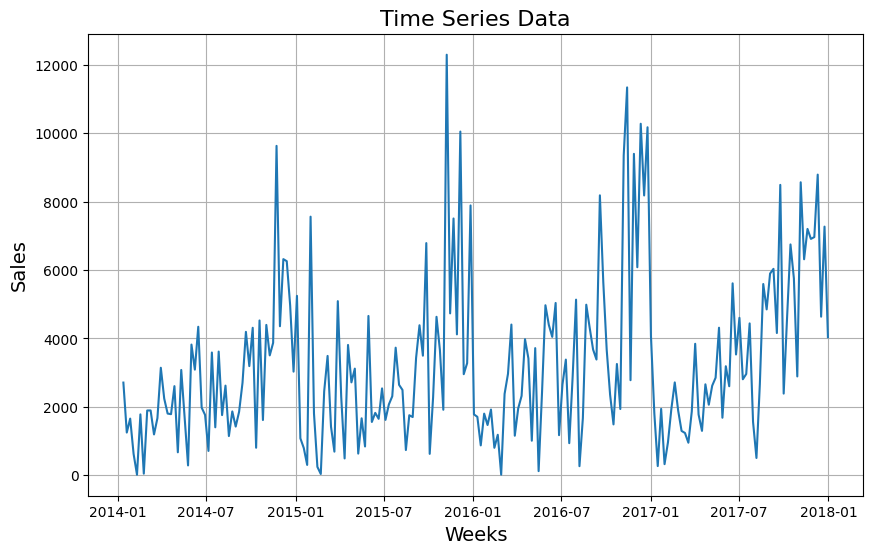

In [ ]:
# Parameters
time = np.arange(len(df.index), dtype="float32")
date = df.index
series = df['sales'].values
print(type(series))
# Plot the results
plot_series(date, series, title = 'Time Series Data', xlabel='Weeks', ylabel='Sales')

## Split the Dataset

In [ ]:
print(len(series))
print(len(series) * 3 / 4)

208
156.0


In [ ]:
# Define the split time
split_time = round(len(series) * 3 / 4)

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
print(len(time_valid))

52


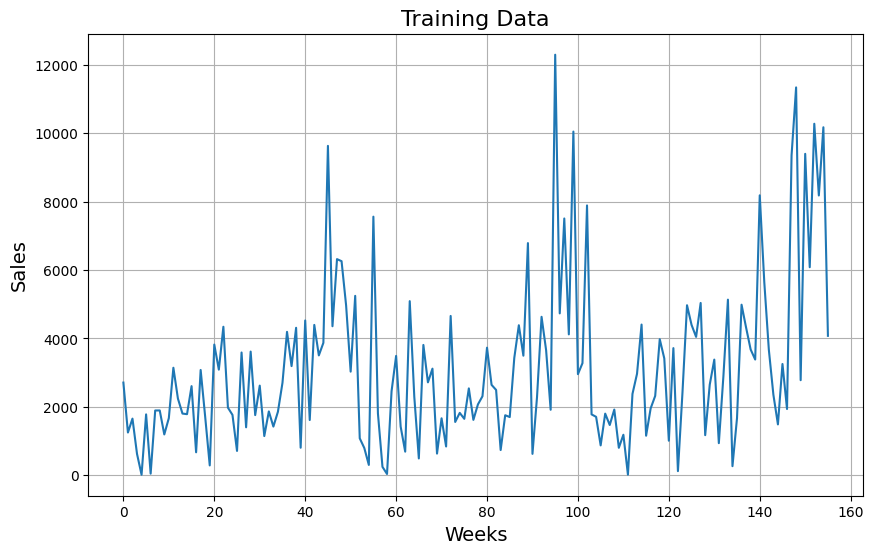

In [ ]:
plot_series(time_train, x_train, title = 'Training Data', xlabel='Weeks', ylabel='Sales')

## Prepare Features and Labels

In [ ]:
# Parameters
window_size = 26
batch_size = 16
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (16, 26)
shape of label: (16,)


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routs its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`.

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [ ]:
node = int(26)

In [ ]:

# Build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(node, return_sequences=True),
    tf.keras.layers.SimpleRNN(node),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 26, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 26, 26)            728       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 26)                1378      
                                                                 
 dense (Dense)               (None, 1)                 27        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 2,133
Trainable params: 2,133
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [ ]:
# Get initial weights
init_weights = model_tune.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
9/9 [==============================] - 3s 46ms/step - loss: 1855.1993 - lr: 1.0000e-08
Epoch 2/100
9/9 [==============================] - 0s 43ms/step - loss: 1855.1993 - lr: 1.1220e-08
Epoch 3/100
9/9 [==============================] - 0s 45ms/step - loss: 1855.1993 - lr: 1.2589e-08
Epoch 4/100
9/9 [==============================] - 0s 45ms/step - loss: 1855.1992 - lr: 1.4125e-08
Epoch 5/100
9/9 [==============================] - 1s 88ms/step - loss: 1855.1993 - lr: 1.5849e-08
Epoch 6/100
9/9 [==============================] - 1s 92ms/step - loss: 1855.1992 - lr: 1.7783e-08
Epoch 7/100
9/9 [==============================] - 1s 70ms/step - loss: 1855.1992 - lr: 1.9953e-08
Epoch 8/100
9/9 [==============================] - 0s 51ms/step - loss: 1855.1992 - lr: 2.2387e-08
Epoch 9/100
9/9 [==============================] - 0s 48ms/step - loss: 1855.1992 - lr: 2.5119e-08
Epoch 10/100
9/9 [==============================] - 0s 43ms/step - loss: 1855.1992 - lr: 2.8184e-08
Epoch 11/

You can visualize the results and pick an optimal learning rate.

Text(0.5, 1.0, 'Finding Optimal Learning Rate')

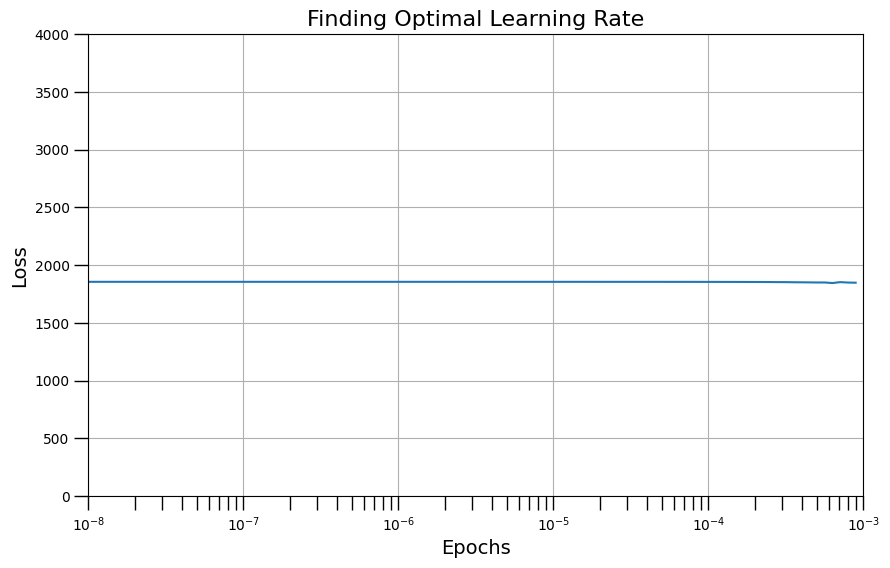

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 4000])
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Finding Optimal Learning Rate', fontsize=16)

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

In [ ]:
'''
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size and create a transparent background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')

# Set the grid
ax.grid(True)

# Plot the loss in log scale
ax.semilogx(lrs, history.history["loss"])

# Set the plot title
ax.set_title("Learning Rate vs. Loss")

# Set the x-label
ax.set_xlabel("Learning Rate")

# Set the y-label
ax.set_ylabel("Loss")

# Increase the tickmarks size
ax.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
ax.axis([1e-7, 1e-3, 0, 60])

# Make the background transparent
fig.patch.set_alpha(0)
fig.patch.set_facecolor('none')
ax.set_facecolor('none')

# Show the plot
plt.show()
'''

'\n# Define the learning rate array\nlrs = 1e-8 * (10 ** (np.arange(100) / 20))\n\n# Set the figure size and create a transparent background\nfig, ax = plt.subplots(figsize=(10, 6), facecolor=\'none\')\n\n# Set the grid\nax.grid(True)\n\n# Plot the loss in log scale\nax.semilogx(lrs, history.history["loss"])\n\n# Set the plot title\nax.set_title("Learning Rate vs. Loss")\n\n# Set the x-label\nax.set_xlabel("Learning Rate")\n\n# Set the y-label\nax.set_ylabel("Loss")\n\n# Increase the tickmarks size\nax.tick_params(\'both\', length=10, width=1, which=\'both\')\n\n# Set the plot boundaries\nax.axis([1e-7, 1e-3, 0, 60])\n\n# Make the background transparent\nfig.patch.set_alpha(0)\nfig.patch.set_facecolor(\'none\')\nax.set_facecolor(\'none\')\n\n# Show the plot\nplt.show()\n'

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [ ]:
# Get initial weights
init_weights = model_tune.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()


# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(node, return_sequences=True),
  tf.keras.layers.SimpleRNN(node),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


# Set the learning rate
learning_rate = 3e-5

# Set the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=500)

Epoch 1/500
9/9 [==============================] - 3s 46ms/step - loss: 3346.4185 - mae: 3346.9185
Epoch 2/500
9/9 [==============================] - 0s 45ms/step - loss: 3211.6455 - mae: 3212.1455
Epoch 3/500
9/9 [==============================] - 0s 51ms/step - loss: 3097.1272 - mae: 3097.6272
Epoch 4/500
9/9 [==============================] - 0s 43ms/step - loss: 3013.4482 - mae: 3013.9482
Epoch 5/500
9/9 [==============================] - 0s 51ms/step - loss: 2939.4609 - mae: 2939.9609
Epoch 6/500
9/9 [==============================] - 1s 52ms/step - loss: 2872.8452 - mae: 2873.3452
Epoch 7/500
9/9 [==============================] - 0s 45ms/step - loss: 2817.8701 - mae: 2818.3701
Epoch 8/500
9/9 [==============================] - 0s 44ms/step - loss: 2773.4250 - mae: 2773.9250
Epoch 9/500
9/9 [==============================] - 0s 47ms/step - loss: 2739.0271 - mae: 2739.5271
Epoch 10/500
9/9 [==============================] - 0s 42ms/step - loss: 2710.1533 - mae: 2710.6533
Epoch 11/

In [ ]:
# Initialize empty lists to store training and validation losses
train_losses = []
valid_losses = []
epochs = 500

# Train the model
for epoch in range(epochs):
    # Train the model on the training set
    history = model.fit(train_set, epochs=1, verbose=0)

    # Calculate training loss and append to list
    train_loss = float(history.history['loss'][0])
    train_losses.append(train_loss)


    # Use helper function to generate predictions
    forecast = model_forecast(model, forecast_series, window_size, batch_size)

    # Drop single dimensional axis
    results = forecast.squeeze()

    valid_loss = float(keras.losses.Huber()(x_valid, results).numpy())
    valid_losses.append(valid_loss)

    # Print progress
    print("Epoch {}/{} - ".format(epoch + 1, epochs))
    print("Train Loss: ", train_loss, "Valid Loss: ", valid_loss)

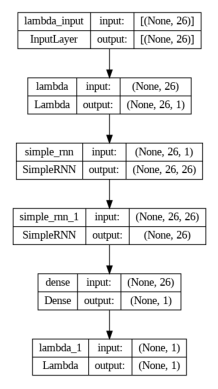

In [ ]:
from io import BytesIO
# Create a buffer to save the model summary image
buffer = BytesIO()

# Plot the model summary and save it to a file
tf.keras.utils.plot_model(model, to_file="model_summary.png", show_shapes=True, show_layer_names=True)

# Display the saved image
img = plt.imread("model_summary.png")
plt.imshow(img)
plt.axis('off')
plt.show()

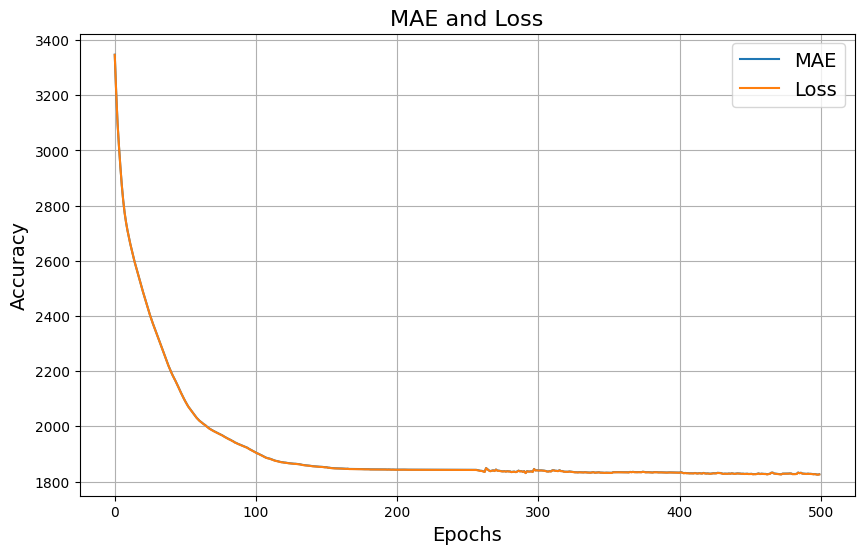

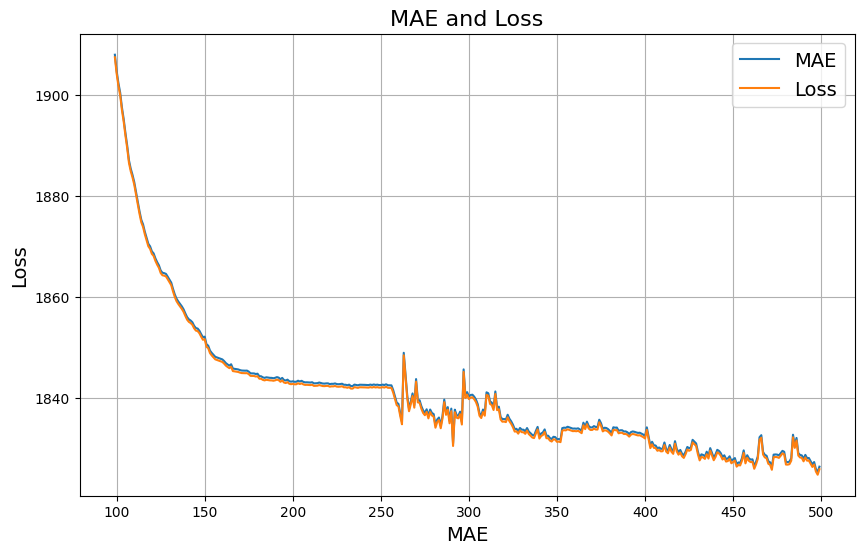

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    ylabel='Accuracy',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

In [ ]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))


# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Ensure all values are positive
results = np.abs(results)

# Plot the results
#plot_series(time_valid, (x_valid, results), 'RNN Prediction')

1/1 [==============================] - 0s 23ms/step


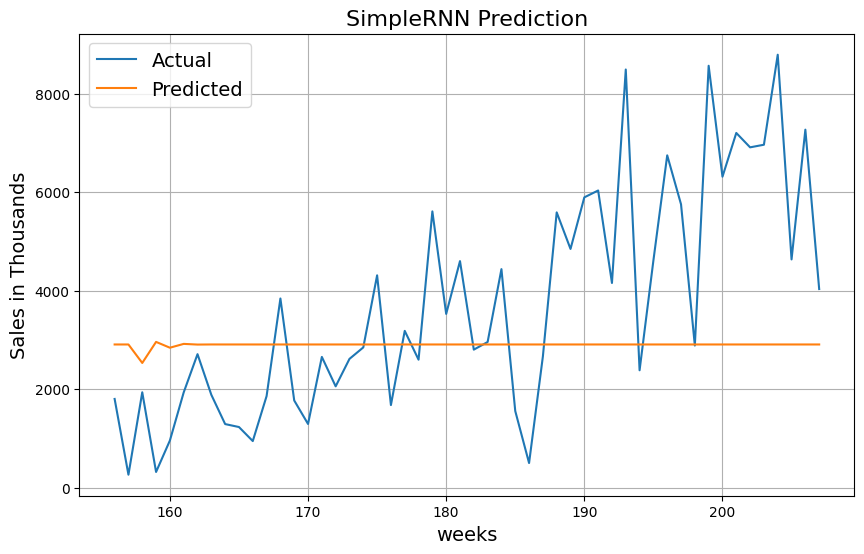

In [ ]:
plot_series(time_valid, (x_valid, results), '-', 0, None, 'SimpleRNN Prediction', 'weeks', 'Sales in Thousands', legend = ("Actual", "Predicted"))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

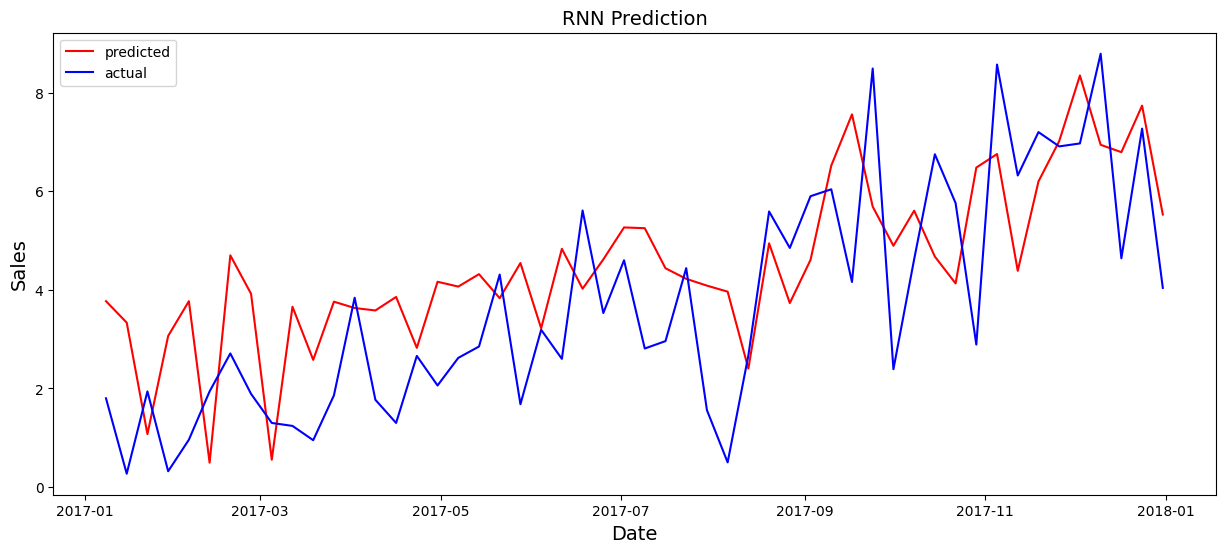

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
# Set the background color to transparent
f.patch.set_facecolor('none')
ax.set_facecolor('none')
sns.lineplot(x=date[split_time:], y=results, ax=ax, color='red', label='predicted') #navajowhite
sns.lineplot(x=date[split_time:], y=x_valid, ax=ax, color='blue', label='actual') #navajowhite
ax.set_title(f'RNN Prediction', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)

plt.show()

In [ ]:
'''def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast
    '''

'def model_forecast(model, series, window_size, batch_size):\n    """Uses an input model to generate predictions on data windows\n\n    Args:\n      model (TF Keras Model) - model that accepts data windows\n      series (array of float) - contains the values of the time series\n      window_size (int) - the number of time steps to include in the window\n      batch_size (int) - the batch size\n\n    Returns:\n      forecast (numpy array) - array containing predictions\n    """\n\n    # Generate a TF Dataset from the series values\n    dataset = tf.data.Dataset.from_tensor_slices(series)\n\n    # Window the data but only take those with the specified size\n    dataset = dataset.window(window_size, shift=1, drop_remainder=True)\n\n    # Flatten the windows by putting its elements in a single batch\n    dataset = dataset.flat_map(lambda w: w.batch(window_size))\n\n    # Create batches of windows\n    dataset = dataset.batch(batch_size).prefetch(1)\n\n    # Get predictions on the entire da

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

In [ ]:
'''# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))'''

'# Reduce the original series\nforecast_series = series[split_time - window_size:-1]\n\n# Use helper function to generate predictions\nforecast = model_forecast(model, forecast_series, window_size, batch_size)\n\n# Drop single dimensional axis\nresults = forecast.squeeze()\n\n# Plot the results\nplot_series(time_valid, (x_valid, results))'

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [ ]:
# Assuming y_true contains the true target values and y_pred contains the predicted values
def r2_score(y_true, y_pred):
    SS_res = np.sum((y_true - y_pred)**2)
    SS_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (SS_res / SS_tot)
    return r2

In [ ]:
import sklearn
# Compute the RMSE and MAE
print('MAE', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print('RMSE', math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy()))
print('R^2', sklearn.metrics.r2_score(x_valid, results))
r2 = r2_score(x_valid, results)
print("R2 score (defined):", r2)

MAE 1.6427935
RMSE 1.8889878806497349
R^2 0.3114159703199473
R2 score (defined): 0.3114159703199473


In [ ]:
'''best is saved, do not run'''

'best is saved, do not run'